In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
plt.style.use('dark_background')


# 1. Генерация данных

In [10]:
N = 50

np.random.seed(777)

data1 = np.random.randn(N)
data3 = np.random.randn(N)

alpha = 0.5  # коэффициент, определяющий степень зависимости
noise = np.random.randn(N) * 0.5  # шум, чтобы данные не были полностью зависимыми
data2 = alpha * data1 + noise

data1 += 0.5 * np.sin(2 * np.pi * data1 / 12)
data2 += 0.5 * np.sin(2 * np.pi * data2 / 12 + np.pi / 2)
data3 += 0.5 * np.sin(2 * np.pi * data3 / 12 + np.pi)

window_size = 3
data1_smoothed = np.convolve(data1, np.ones(window_size), 'valid') / window_size
data2_smoothed = np.convolve(data2, np.ones(window_size), 'valid') / window_size
data3_smoothed = np.convolve(data3, np.ones(window_size), 'valid') / window_size

df = pd.DataFrame({
    'data1_sm': data1_smoothed,
    'data2_sm': data2_smoothed,
    'data3_sm': data3_smoothed,
})



# 2. Описание  данных 


## Средние и дисперсия

In [11]:
print("Среднее значение и дисперсия исходных данных:")
print(df[['data1_sm', 'data2_sm', 'data3_sm']].mean())
print(df[['data1_sm', 'data2_sm', 'data3_sm']].var())


Среднее значение и дисперсия исходных данных:
data1_sm    0.032764
data2_sm    0.558852
data3_sm   -0.020724
dtype: float64
data1_sm    0.630828
data2_sm    0.191175
data3_sm    0.180830
dtype: float64


## Построение графиков временных рядов


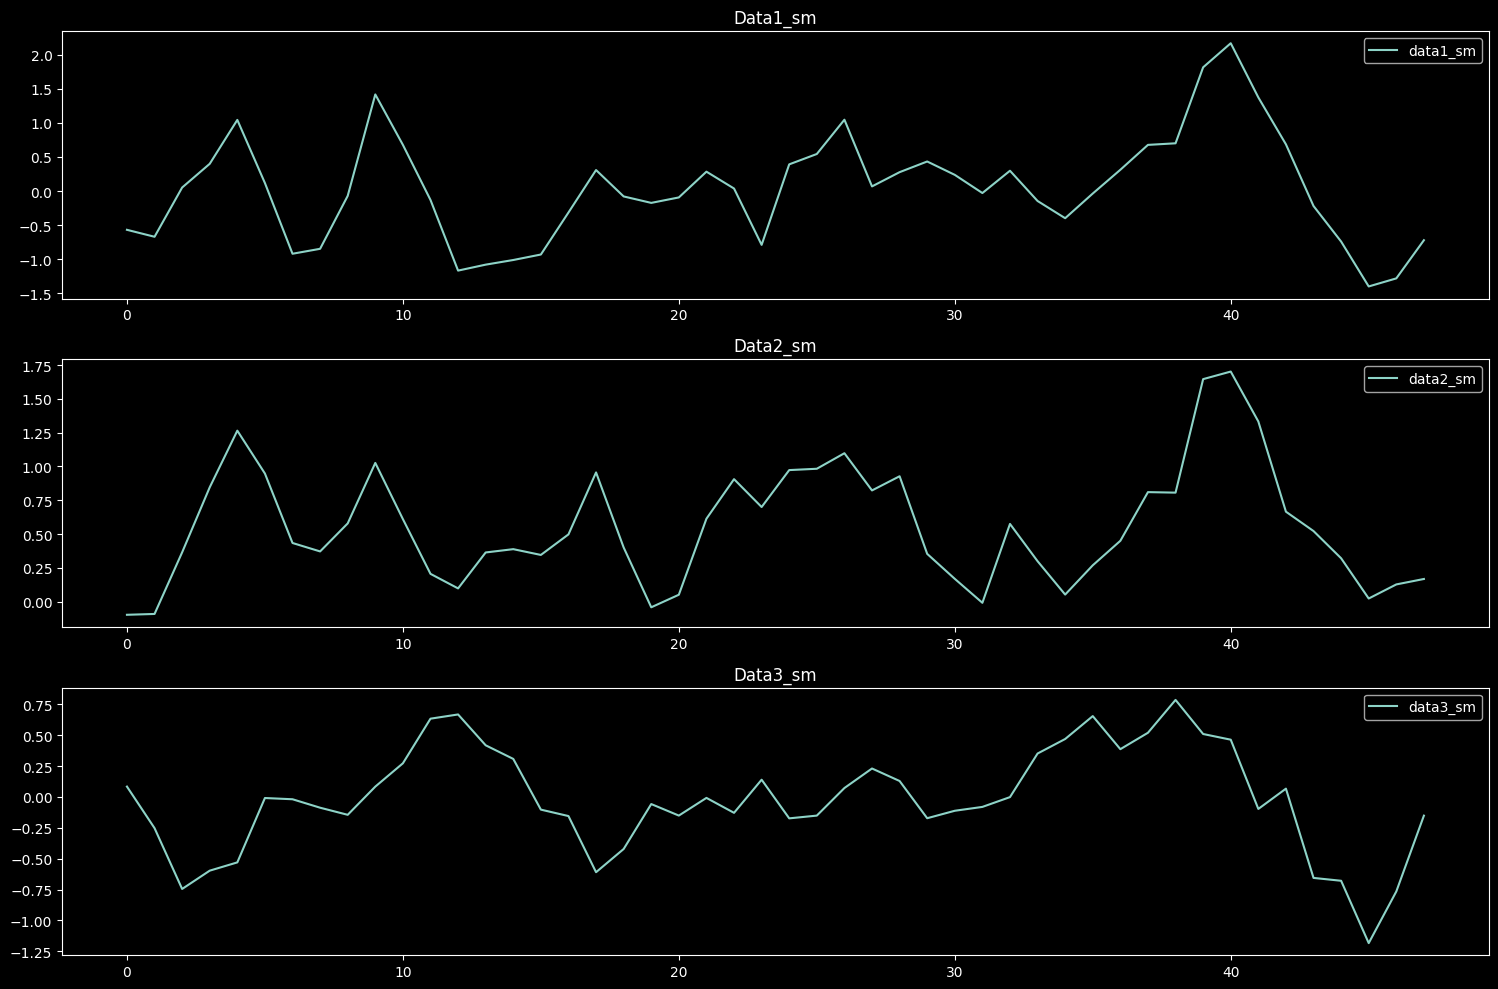

In [12]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['data1_sm'], label='data1_sm')
plt.title('Data1_sm')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['data2_sm'], label='data2_sm')
plt.title('Data2_sm')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['data3_sm'], label='data3_sm')
plt.title('Data3_sm')
plt.legend()

plt.tight_layout()
plt.show()


## Анализ динамики

Построим графики темпов роста:


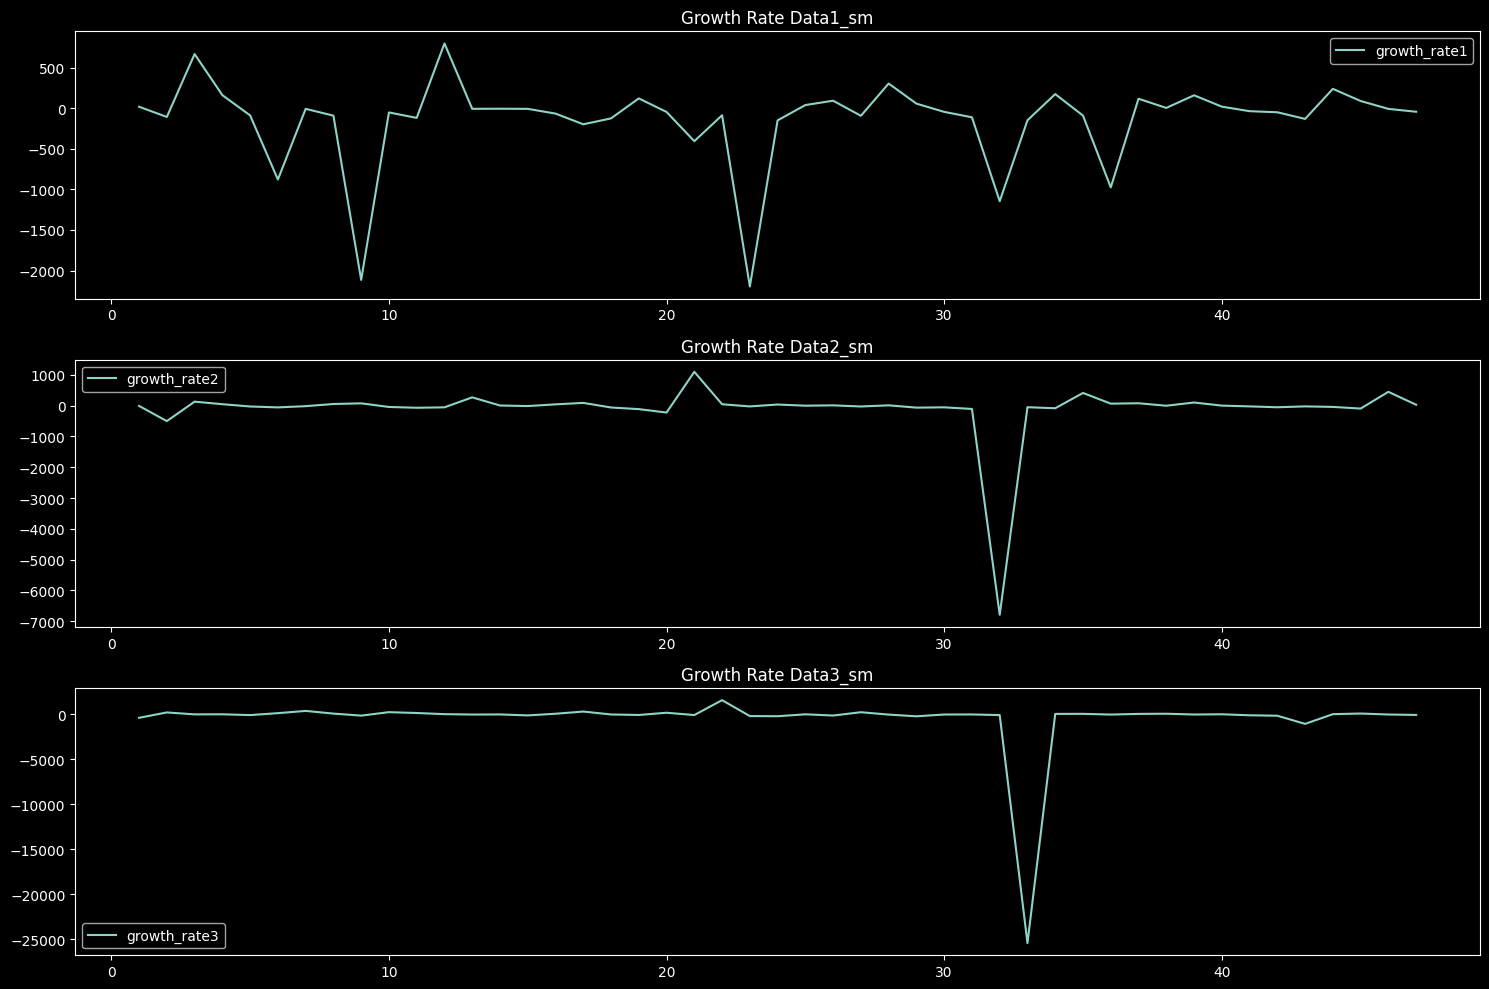

In [21]:
growth_rate1 = df['data1_sm'].pct_change() * 100
growth_rate2 = df['data2_sm'].pct_change() * 100
growth_rate3 = df['data3_sm'].pct_change() * 100

df['growth_rate1'] = growth_rate1
df['growth_rate2'] = growth_rate2
df['growth_rate3'] = growth_rate3

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['growth_rate1'], label='growth_rate1')
plt.title('Growth Rate Data1_sm')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['growth_rate2'], label='growth_rate2')
plt.title('Growth Rate Data2_sm')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['growth_rate3'], label='growth_rate3')
plt.title('Growth Rate Data3_sm')
plt.legend()

plt.tight_layout()
plt.show()

df = df.drop(['growth_rate1','growth_rate2','growth_rate3'], axis = 1)


## Вычисление коррелограммы

Коррелограмма включает автокорреляционную функцию (ACF) и частную автокорреляционную функцию (PACF). Мы используем библиотеку statsmodels для построения этих функций.


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

plot_acf(df['data1_sm'], lags=20, ax=ax[0, 0])
ax[0, 0].set_title('ACF Data1_sm')
plot_pacf(df['data1_sm'], lags=20, ax=ax[0, 1])
ax[0, 1].set_title('PACF Data1_sm')

plot_acf(df['data2_sm'], lags=20, ax=ax[1, 0])
ax[1, 0].set_title('ACF Data2_sm')
plot_pacf(df['data2_sm'], lags=20, ax=ax[1, 1])
ax[1, 1].set_title('PACF Data2_sm')

plot_acf(df['data3_sm'], lags=20, ax=ax[2, 0])
ax[2, 0].set_title('ACF Data3_sm')
plot_pacf(df['data3_sm'], lags=20, ax=ax[2, 1])
ax[2, 1].set_title('PACF Data3_sm')

plt.tight_layout()
plt.show()


# 3. Стационарность

## определим тесты на стационарность

In [22]:
def adfuller_test(series, signif=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] <= signif

def kpss_test(series, signif=0.05):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1] > signif

def phillips_perron_test(series, signif=0.05):
    pp_result = PhillipsPerron(series.dropna())
    return pp_result.pvalue <= signif

def is_stationary(series, signif=0.05):
    return adfuller_test(series, signif) and kpss_test(series, signif) and phillips_perron_test(series, signif)


## Проверяем на стационарность ряды. 
Если стационарны, то береём последовательные рвзности, пока ряд не станет стационарным

In [23]:
df_diffed = df.copy()
max_diff = 10  # Максимальное количество дифференцирований на случай, если нет сходимости

for column in df.columns:
    diff_count = 0
    stationary = False
    
    print(f"Проверка стационарности для переменной {column}, исходный ряд:")
    while not stationary and diff_count < max_diff:
        stationary = is_stationary(df_diffed[column])
        if not stationary:
            df_diffed[column] = df_diffed[column].diff().dropna()
            diff_count += 1
    
    if stationary:
        print(f"Переменная {column} стала стационарной после {diff_count} дифференцирований.\n")
    else:
        print(f"Не удалось сделать переменную {column} стационарной после {max_diff} дифференцирований.\n")



Проверка стационарности для переменной data1_sm, исходный ряд:
Переменная data1_sm стала стационарной после 1 дифференцирований.

Проверка стационарности для переменной data2_sm, исходный ряд:
Переменная data2_sm стала стационарной после 1 дифференцирований.

Проверка стационарности для переменной data3_sm, исходный ряд:
Переменная data3_sm стала стационарной после 1 дифференцирований.



/tmp/ipykernel_1464/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipykernel_1464/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipykernel_1464/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
/tmp/ipykernel_1464/3005623357.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value return

### Вывод о порядке интегрируемости и наличии детерминированного тренда

После проверки временных рядов можно сделать вывод о порядке интегрируемости данных.

### Результаты

Результаты показывают, что все три переменные data1_sm, data2_sm и data3_sm стали стационарными после одного дифференцирования.


### Порядок интегрируемости

Если временной ряд становится стационарным после одного дифференцирования, он называется интегрированным порядком один или \(I(1)\). Это означает, что все три временных ряда в наличии данных являются \(I(1)\) процессами.

### Детерминированный тренд

Данные, которые требуют первого дифференцирования для достижения стационарности, часто имеют детерминированный тренд. Это подтверждается наличием синусоидальных составляющих в исходных данных, что указывает на сезонные эффекты и детерминированный тренд.

### Заключение

- Порядок интегрируемости: Все три временных ряда (data1_sm, data2_sm, data3_sm) имеют порядок интегрируемости 1, то есть \(I(1)\), поскольку они стали стационарными после одного дифференцирования.
- Детерминированный тренд: Наличие детерминированного тренда подтверждается тем, что ряды стали стационарными после первого дифференцирования, что указывает на наличие долгосрочного тренда в исходных данных, который был устранен путем дифференцирования.

Таким образом, временные ряды в данных имеют детерминированный тренд и могут быть преобразованы в стационарные ряды первого порядка интегрируемости \(I(1)\).
